In [14]:
import random
import simpy
import math

NEW_CUSTOMERS =5  # Número total de clientes
INTERVAL_CUSTOMERS = 10.0  # Generar nuevos clientes aproximadamente cada x segundos
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience
TIME_IN_BANK=12.0

CLIENTES=0 #numero de clientes q han entrado al banco
ATENDIDOS=0 #cantidad de clientes atendidos
ABANDONAN=0 #clientes que han abandonado el banco por espera
tfila=0 #suma de tiempo de espera de los clientes en la fila
tbanco=0 #suma de tiempo q el cliente duro en el banco
Tfila=0 #suma de tamaño de fila
fila=[[],[]] #[tiempo][clientes] tiempo de entrada y salida de un cliente de la fila
banco=[[],[]] #[tiempo][clientes] tiempo de entrada y salida de un cliente del banco

SEED_U=24242 #semilla para distribucion uniforme
SEED_E=24242 #semilla para distribucion exponencial

def source(env, nclientes, interval, counter):
    #interval: media deseada del intervalo de tiempo entre la llegada de nuevos clientes
    #counter:  mostrador donde se atiende los clientes
    semilla=5 #semila para exponencial
    
    #Fuente genera clientes azar
    for i in range(nclientes):
        c = customer(env, 'Cliente%02d' % i, counter)
        env.process(c)
        semilla,t=exponencial(semilla,1.0 / interval)
        #t = random.expovariate(1.0 / interval)
        yield env.timeout(t)


def customer(env, name, counter):
    #time_in_bank: media deseada del tiempo en ser atendido el cliente en el cajero
    #counter:  mostrador donde se atiende los clientes
    
    #variables globales
    global ATENDIDOS,ABANDONAN,CLIENTES,tfila,tbanco,Tfila,SEED_U,SEED_E
    #Cliente llega, se sirve y se va
    arrive = env.now #llegada de un cliente
    
    CLIENTES+=1;
    banco[0].append(arrive)
    banco[1].append(CLIENTES-ATENDIDOS-ABANDONAN)
    if CLIENTES-ATENDIDOS-ABANDONAN > 1:
        fila[0].append(arrive)
        fila[1].append(CLIENTES-ATENDIDOS-ABANDONAN-1)
    '''Cliente llego al banco'''
    print('%7.4f %s: Aquí estoy' % (arrive, name))
    
    with counter.request() as req:
        SEED_U,patience = uniforme(SEED_U,MIN_PATIENCE, MAX_PATIENCE)
        print(' con una paciencia de '+str(patience))
        
        results = yield req | env.timeout(patience)
        
        Tfila +=CLIENTES-ATENDIDOS-ABANDONAN-1
        if CLIENTES-ATENDIDOS-ABANDONAN > 1:
            fila[0].append(env.now)
            fila[1].append(CLIENTES-ATENDIDOS-ABANDONAN-2)
        
        wait = env.now - arrive
        
        tfila+=wait
        
        if req in results:
            '''Llego al mostrador'''
            print('%7.4f %s: Esperado %6.3f' % (env.now, name, wait))
            
            SEED_E,tib = exponencial(SEED_E,1.0 / TIME_IN_BANK)
            print('Tiempo de atencion: '+str(tib))
            yield env.timeout(tib)
            '''Mostramos q termino'''
            print('%7.4f %s: Terminado' % (env.now, name))
            ATENDIDOS+=1;
        else:
            '''Mostramos la salida'''
            print('%7.4f %s: RENEGO despues de %6.3f' % (env.now, name, wait))
            ABANDONAN+=1
        tbanco=env.now-arrive
        banco[0].append(env.now)
        banco[1].append(CLIENTES- ATENDIDOS-ABANDONAN)
        
def Aleatorio(x):
    a=1664525
    b=1013904223
    m=2**32
    x=(a*x+b)%m
    u=float(x)/m
    return u,x

#exponencial[semilla,landa]:(semilla,variable aleatoria)
def exponencial(x,landa):
    u,x = Aleatorio(x)
    return x,-math.log(1-u)/landa
#uniforme[semilla,a,b](semilla,variable aleatoria)
def uniforme(x,a,b):
    u,x = Aleatorio(x)
    return x,a+u*(b-a)

# Empezamos simulacion
env = simpy.Environment()
# Start processes and run
counter = simpy.Resource(env, capacity=1)#cantidad de mostradores
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

 0.0000 Cliente00: Aquí estoy
 con una paciencia de 2.262227822560817
 0.0000 Cliente00: Esperado  0.000
Tiempo de atencion: 11.967208623084206
 2.7182 Cliente01: Aquí estoy
 con una paciencia de 1.238483989611268
 3.9566 Cliente01: RENEGO despues de  1.238
11.9672 Cliente00: Terminado
15.8890 Cliente02: Aquí estoy
 con una paciencia de 2.03494364162907
15.8890 Cliente02: Esperado  0.000
Tiempo de atencion: 1.5236684728401406
17.4127 Cliente02: Terminado
18.6740 Cliente03: Aquí estoy
 con una paciencia de 1.0372185735031962
18.6740 Cliente03: Esperado  0.000
Tiempo de atencion: 8.744591489418376
27.4185 Cliente03: Terminado
37.8437 Cliente04: Aquí estoy
 con una paciencia de 2.7181963534094393
37.8437 Cliente04: Esperado  0.000
Tiempo de atencion: 0.22541541756024164
38.0691 Cliente04: Terminado


Número de clientes que llegaron: 5
Número de clientes que fueron atendidos en el banco: 4
Número de clientes que abandonaron el banco: 1
Tiempo promedio de espera del cliente en la fila: 0.2476967979222536
Tiempo promedio del cliente en el banco: 0.04508308351204846
Tamaño promedio de la fila: 0.2


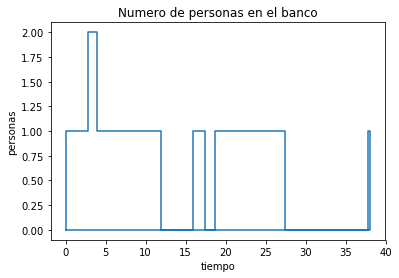

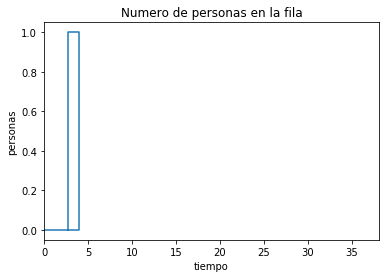

In [12]:
def estadisticas():
    print('Número de clientes que llegaron: '+str(CLIENTES))
    print('Número de clientes que fueron atendidos en el banco: '+str(ATENDIDOS))
    print('Número de clientes que abandonaron el banco: '+str(ABANDONAN))
    print('Tiempo promedio de espera del cliente en la fila: '+str(tfila/CLIENTES))
    print('Tiempo promedio del cliente en el banco: '+str(tbanco/CLIENTES))
    print('Tamaño promedio de la fila: '+str(Tfila/CLIENTES))

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def grafica():
    #banco
    xb=np.repeat(banco[0],2).tolist()
    xb.append(0)
    tb=np.repeat(banco[1],2).tolist()
    tb.insert(0,0)
    
    plt.title('Numero de personas en el banco')
    plt.plot(xb,tb)
    plt.ylabel('personas')
    plt.xlabel('tiempo')
    plt.show()
    
    #fila
    xf=np.repeat(fila[0],2).tolist()
    xf.append(0)
    tf=np.repeat(fila[1],2).tolist()
    tf.insert(0,0)
    
    plt.plot(xf,tf)
    plt.title('Numero de personas en la fila')
    plt.xlim(0,max(banco[0]))
    plt.ylabel('personas')
    plt.xlabel('tiempo')
    plt.show()
estadisticas()
grafica()

### Realice las simulaciones calculando y graficando lo que implementó, para los siguiente escenarios:

### Escenaria 1


Escenario A
 0.0000 Cliente00: Aquí estoy
 con una paciencia de 3.262227822560817
 0.0000 Cliente00: Esperado  0.000
Tiempo de atencion: 12.96447600834122
 1.3591 Cliente01: Aquí estoy
 con una paciencia de 2.238483989611268
 3.5976 Cliente01: RENEGO despues de  2.238
 7.9445 Cliente02: Aquí estoy
 con una paciencia de 3.03494364162907
 9.3370 Cliente03: Aquí estoy
 con una paciencia de 2.0372185735031962
10.9795 Cliente02: RENEGO despues de  3.035
11.3742 Cliente03: RENEGO despues de  2.037
12.9645 Cliente00: Terminado
18.9218 Cliente04: Aquí estoy
 con una paciencia de 3.7181963534094393
18.9218 Cliente04: Esperado  0.000
Tiempo de atencion: 1.650640845576819
20.5725 Cliente04: Terminado


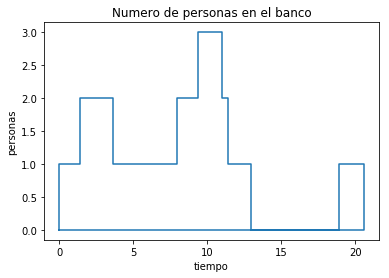

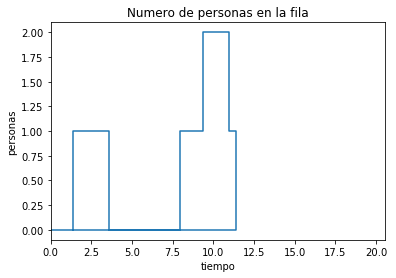

Número de clientes que llegaron: 5
Número de clientes que fueron atendidos en el banco: 2
Número de clientes que abandonaron el banco: 3
Tiempo promedio de espera del cliente en la fila: 1.4621292409487068
Tiempo promedio del cliente en el banco: 0.330128169115364
Tamaño promedio de la fila: 0.8


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
'''Primero'''
INTERVAL_CUSTOMERS = 5.0  # Generar nuevos clientes aproximadamente cada x segundos
MIN_PATIENCE = 2  # Min. customer patience
MAX_PATIENCE = 4  # Max. customer patience
TIME_IN_BANK=13.0

print('Escenario A')
CLIENTES=0 #numero de clientes q han entrado al banco
ATENDIDOS=0 #cantidad de clientes atendidos
ABANDONAN=0 #clientes que han abandonado el banco por espera
tfila=0 #suma de tiempo de espera de los clientes en la fila
tbanco=0 #suma de tiempo q el cliente duro en el banco
Tfila=0 #suma de tamaño de fila
fila=[[],[]] #[tiempo][clientes] tiempo de entrada y salida de un cliente de la fila
banco=[[],[]] #[tiempo][clientes] tiempo de entrada y salida de un cliente del banco

SEED_U=24242 #semilla para distribucion uniforme
SEED_E=24242 #semilla para distribucion exponencial

env = simpy.Environment()
# Start processes and run
counter = simpy.Resource(env, capacity=1)#cantidad de mostradores
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()


#banco
xb=np.repeat(banco[0],2).tolist()
xb.append(0)
tb=np.repeat(banco[1],2).tolist()
tb.insert(0,0)

plt.title('Numero de personas en el banco')
plt.plot(xb,tb)
plt.ylabel('personas')
plt.xlabel('tiempo')
plt.show()

#fila
xf=np.repeat(fila[0],2).tolist()
xf.append(0)
tf=np.repeat(fila[1],2).tolist()
tf.insert(0,0)

plt.plot(xf,tf)
plt.title('Numero de personas en la fila')
plt.xlim(0,max(banco[0]))
plt.ylabel('personas')
plt.xlabel('tiempo')
plt.show()


print('Número de clientes que llegaron: '+str(CLIENTES))
print('Número de clientes que fueron atendidos en el banco: '+str(ATENDIDOS))
print('Número de clientes que abandonaron el banco: '+str(ABANDONAN))
print('Tiempo promedio de espera del cliente en la fila: '+str(tfila/CLIENTES))
print('Tiempo promedio del cliente en el banco: '+str(tbanco/CLIENTES))
print('Tamaño promedio de la fila: '+str(Tfila/CLIENTES))


### Escenario 2

Escenario B
 0.0000 Cliente00: Aquí estoy
 con una paciencia de 2.262227822560817
 0.0000 Cliente00: Esperado  0.000
Tiempo de atencion: 8.975406467313155
 3.2618 Cliente01: Aquí estoy
 con una paciencia de 1.238483989611268
 4.5003 Cliente01: RENEGO despues de  1.238
 8.9754 Cliente00: Terminado
19.0669 Cliente02: Aquí estoy
 con una paciencia de 2.03494364162907
19.0669 Cliente02: Esperado  0.000
Tiempo de atencion: 1.1427513546301056
20.2096 Cliente02: Terminado
22.4087 Cliente03: Aquí estoy
 con una paciencia de 1.0372185735031962
22.4087 Cliente03: Esperado  0.000
Tiempo de atencion: 6.558443617063782
28.9672 Cliente03: Terminado
45.4124 Cliente04: Aquí estoy
 con una paciencia de 2.7181963534094393
45.4124 Cliente04: Esperado  0.000
Tiempo de atencion: 0.16906156317018123
45.5815 Cliente04: Terminado


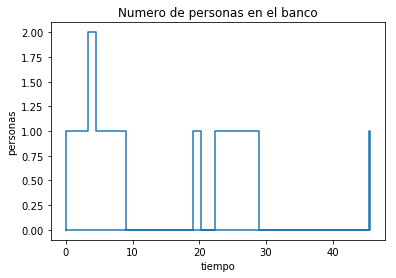

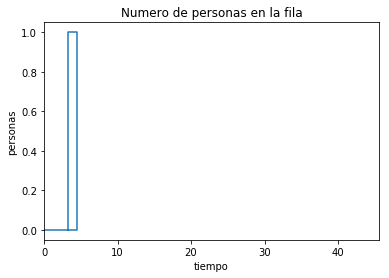

Número de clientes que llegaron: 5
Número de clientes que fueron atendidos en el banco: 4
Número de clientes que abandonaron el banco: 1
Tiempo promedio de espera del cliente en la fila: 0.2476967979222537
Tiempo promedio del cliente en el banco: 0.03381231263403635
Tamaño promedio de la fila: 0.2


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
'''Segundo'''
INTERVAL_CUSTOMERS = 12.0  # Generar nuevos clientes aproximadamente cada x segundos
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience
TIME_IN_BANK=9.0

print('Escenario B')
CLIENTES=0 #numero de clientes q han entrado al banco
ATENDIDOS=0 #cantidad de clientes atendidos
ABANDONAN=0 #clientes que han abandonado el banco por espera
tfila=0 #suma de tiempo de espera de los clientes en la fila
tbanco=0 #suma de tiempo q el cliente duro en el banco
Tfila=0 #suma de tamaño de fila
fila=[[],[]] #[tiempo][clientes] tiempo de entrada y salida de un cliente de la fila
banco=[[],[]] #[tiempo][clientes] tiempo de entrada y salida de un cliente del banco

SEED_U=24242 #semilla para distribucion uniforme
SEED_E=24242 #semilla para distribucion exponencial

env = simpy.Environment()
# Start processes and run
counter = simpy.Resource(env, capacity=1)#cantidad de mostradores
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()
#banco
xb=np.repeat(banco[0],2).tolist()
xb.append(0)
tb=np.repeat(banco[1],2).tolist()
tb.insert(0,0)

plt.title('Numero de personas en el banco')
plt.plot(xb,tb)
plt.ylabel('personas')
plt.xlabel('tiempo')
plt.show()

#fila
xf=np.repeat(fila[0],2).tolist()
xf.append(0)
tf=np.repeat(fila[1],2).tolist()
tf.insert(0,0)

plt.plot(xf,tf)
plt.title('Numero de personas en la fila')
plt.xlim(0,max(banco[0]))
plt.ylabel('personas')
plt.xlabel('tiempo')
plt.show()


print('Número de clientes que llegaron: '+str(CLIENTES))
print('Número de clientes que fueron atendidos en el banco: '+str(ATENDIDOS))
print('Número de clientes que abandonaron el banco: '+str(ABANDONAN))
print('Tiempo promedio de espera del cliente en la fila: '+str(tfila/CLIENTES))
print('Tiempo promedio del cliente en el banco: '+str(tbanco/CLIENTES))
print('Tamaño promedio de la fila: '+str(Tfila/CLIENTES))


Escenario C
 0.0000 Cliente00: Aquí estoy
 con una paciencia de 3.262227822560817
 0.0000 Cliente00: Esperado  0.000
Tiempo de atencion: 12.96447600834122
 1.3591 Cliente01: Aquí estoy
 con una paciencia de 2.238483989611268
 3.5976 Cliente01: RENEGO despues de  2.238
 7.9445 Cliente02: Aquí estoy
 con una paciencia de 3.03494364162907
 9.3370 Cliente03: Aquí estoy
 con una paciencia de 2.0372185735031962
10.9795 Cliente02: RENEGO despues de  3.035
11.3742 Cliente03: RENEGO despues de  2.037
12.9645 Cliente00: Terminado
18.9218 Cliente04: Aquí estoy
 con una paciencia de 3.7181963534094393
18.9218 Cliente04: Esperado  0.000
Tiempo de atencion: 1.650640845576819
20.5725 Cliente04: Terminado


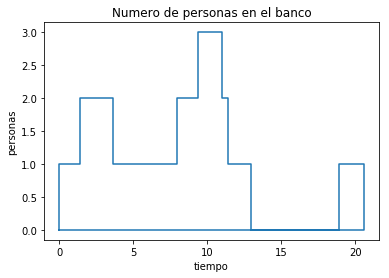

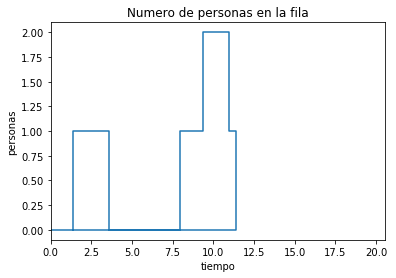

Número de clientes que llegaron: 5
Número de clientes que fueron atendidos en el banco: 2
Número de clientes que abandonaron el banco: 3
Tiempo promedio de espera del cliente en la fila: 1.4621292409487068
Tiempo promedio del cliente en el banco: 0.330128169115364
Tamaño promedio de la fila: 0.8


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
'''Tercero'''
INTERVAL_CUSTOMERS = 5.0  # Generar nuevos clientes aproximadamente cada x segundos
MIN_PATIENCE = 2  # Min. customer patience
MAX_PATIENCE = 4  # Max. customer patience
TIME_IN_BANK=13.0

print('Escenario C')
CLIENTES=0 #numero de clientes q han entrado al banco
ATENDIDOS=0 #cantidad de clientes atendidos
ABANDONAN=0 #clientes que han abandonado el banco por espera
tfila=0 #suma de tiempo de espera de los clientes en la fila
tbanco=0 #suma de tiempo q el cliente duro en el banco
Tfila=0 #suma de tamaño de fila
fila=[[],[]] #[tiempo][clientes] tiempo de entrada y salida de un cliente de la fila
banco=[[],[]] #[tiempo][clientes] tiempo de entrada y salida de un cliente del banco

SEED_U=24242 #semilla para distribucion uniforme
SEED_E=24242 #semilla para distribucion exponencial

env = simpy.Environment()
# Start processes and run
counter = simpy.Resource(env, capacity=1)#cantidad de mostradores
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()


#banco
xb=np.repeat(banco[0],2).tolist()
xb.append(0)
tb=np.repeat(banco[1],2).tolist()
tb.insert(0,0)

plt.title('Numero de personas en el banco')
plt.plot(xb,tb)
plt.ylabel('personas')
plt.xlabel('tiempo')
plt.show()

#fila
xf=np.repeat(fila[0],2).tolist()
xf.append(0)
tf=np.repeat(fila[1],2).tolist()
tf.insert(0,0)

plt.plot(xf,tf)
plt.title('Numero de personas en la fila')
plt.xlim(0,max(banco[0]))
plt.ylabel('personas')
plt.xlabel('tiempo')
plt.show()


print('Número de clientes que llegaron: '+str(CLIENTES))
print('Número de clientes que fueron atendidos en el banco: '+str(ATENDIDOS))
print('Número de clientes que abandonaron el banco: '+str(ABANDONAN))
print('Tiempo promedio de espera del cliente en la fila: '+str(tfila/CLIENTES))
print('Tiempo promedio del cliente en el banco: '+str(tbanco/CLIENTES))
print('Tamaño promedio de la fila: '+str(Tfila/CLIENTES))

## Analisis:
Observando los resultados de ambos escenarios(escenario 1 y 3 son igual solo se evalua escenario 1 y 2) nos podemos dar cuenta que el segundo sobrepasa al primero en atencion a los clientes,esto se refleja en las filas a pesar que el tiempo promedio de los clientes en el banco es muy cercano,el segundo escenario ofrece mejor atencion.